In [1]:
from flightdata import Flight, Fields
import numpy as np
import pandas as pd

logs = []
logs.append(Flight.from_log('./performance_Data/2020_08_14 BUDDI Performance tests/2020-08-14 13-53-54.bin'))
logs.append(Flight.from_log('./performance_Data/2020_08_14 BUDDI Performance tests/2020-08-14 14-15-14.bin'))

In [2]:
import matplotlib.pyplot as plt


def saveplot(name):
    plt.savefig(name + '.svg',bbox_inches='tight')

def matplotplot(width=6, height=6):
    plt.rcParams.update({
        'font.size' : 20,
        "font.family": 'Times New Roman',
        'mathtext.default': 'regular'
    }) 
    fig = plt.figure(figsize=(width, height))
    #fig.set_size_inches(10,3.54) 
    ax = fig.add_subplot(1,1,1)
    return (fig, ax)

def plot_ne_data(data):
    fig, ax = matplotplot(6, 6)
    ax.plot(data['position_y'], data['position_x'], color='black')
    ax.set_xlabel('East, m')
    ax.set_ylabel('North, m')
    ax.grid()
    ax.set_aspect('equal', 'box')

def plot_ne(log):
    plot_ne_data(log.read_fields(Fields.POSITION))


def setupgraph(width, height, xlabel, ylabels):
    plt.rcParams.update({
        'font.size' : 20,
        "font.family": 'Times New Roman',
        'mathtext.default': 'regular'
    }) 
    fig = plt.figure(figsize=(width, height))
    axes = []
    axes.append(fig.add_subplot(1,1,1))
    axes[0].set_ylabel(ylabels[0])
    lastpos = 1
    for label in ylabels[1:]:
        axes.append(axes[0].twinx())
        axes[-1].set_ylabel(label)
        axes[-1].spines['right'].set_position(('axes', lastpos))
        lastpos += 0.13
    return fig, axes 

def addlines(dfs, columns, axis, labels=None, colors=None, linewidths=None):
    if not colors:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    if not linewidths:
        linewidths = [0.75 for i in range(0, len(columns))]
    if not labels:
        labels = columns
    if not isinstance(axis, list):
        axes = [axis for i in range(0, len(columns))]
    else:
        axes = axis
    for df in dfs:
        lns=[]
        for i in range(0, len(columns)):
            lns += axes[i].plot(df[columns[i]],  linewidth=linewidths[i], color=colors[i], label=labels[i])
    return lns
    
plot_ne(logs[0])
plot_ne(logs[1])

In [3]:
from FlightPerformance import DesignPoint
from apc_prop_reader import APCProp
from geometry import Point

buddi_prop = APCProp('PER3_20x13E')

buddi_light = DesignPoint()
buddi_light.mass = 11.66
buddi_light.pe = 0.325
buddi_light.cd0 = 0.03
buddi_light.Capacity = buddi_light.Capacity * 0.5
base_mass = 11.66


apc20x13 = APCProp('PER3_20x13E')


def get_thrust(U, accx, accz, aircraft, bmass=base_mass):
    aircraft.U = U
    aircraft.mass = - bmass * accz / 9.81
    drag_force = aircraft.q * aircraft.S * aircraft.cd
    acc_x_force = accx * bmass
    if acc_x_force < 0:
        acc_x_force=0
    #acc_x_force=0
    return drag_force + acc_x_force    

def get_power(U, thrust, pe):
    return thrust * U / pe

def get_endurance(power, aircraft):
    return ((aircraft.Voltage * aircraft.Capacity / power ) ** aircraft.n ) * aircraft.Rt ** (1 - aircraft.n)

def get_range(power, u, aircraft):
    return get_endurance(power, aircraft) * u

def get_airspeed(vx, vy, vz, vwx, vwy):
    return math.sqrt((vx-vwx)**2 + (vy-vwy)**2 + vz**2)



In [4]:
import math
import functools
from scipy.signal import butter,filtfilt
def generate_prediction(data, prop, aircraft, bmass=base_mass):
    '''predict the thrust, power, endurance and range based on the airspeed and load factor at every data point in the log'''
    
    data['airspeed'] = np.vectorize(get_airspeed)(data['velocity_x'], data['velocity_y'], data['velocity_z'], data['wind_x'], data['wind_y'])
    
    data['thrust'] = np.vectorize(get_thrust)(data['airspeed'], data['acceleration_x'], data['acceleration_z'], aircraft, bmass)
    #data['pe'] = prop.get_pe(np.array(data['airspeed_0']), 0.5 * np.array(data['thrust'])) * aircraft.pe
    
    data['pe'] = np.vectorize(prop.get_pe)(data['airspeed'], 0.5 * data['thrust']) * aircraft.pe
    data['prediction'] = np.vectorize(get_power)(data['airspeed'], data['thrust'], data['pe']) + 2
    
    data['endurance'] = np.vectorize(get_endurance)(np.array(data['prediction']), aircraft)
    data['range'] = np.vectorize(get_range)(np.array(data['prediction']), np.array(data['airspeed']),  aircraft)
    return data

def extract_performance_data(log, prop, aircraft, bmass=base_mass):
    '''make a dataframe for performance data comparisons'''
    
    data = log.read_fields([Fields.BATTERY, Fields.CURRENT, Fields.AIRSPEED, Fields.POSITION, Fields.VELOCITY, Fields.ACCELERATION, Fields.SERVOS, Fields.ATTITUDE, Fields.WIND])

    data=data.loc[pd.isna(data['battery_0'])==False]
    data['power'] = data['battery_0'] * data['current_0'] + data['battery_1'] * data['current_1']
    
    return generate_prediction(data, prop, aircraft, bmass)
    
datas = []
datas.append(extract_performance_data(logs[0], apc20x13, buddi_light))
datas.append(extract_performance_data(logs[1], apc20x13, buddi_light))

In [5]:
from geometry import Point

dxdat = datas[0][['velocity_x', 'velocity_y', 'velocity_z']]
dxdat['dt'] = dxdat.index
accdat = dxdat.diff()

accdat2 = pd.DataFrame([accdat['velocity_x'] / accdat['dt'], accdat['velocity_y'] / accdat['dt'], accdat['velocity_z'] / accdat['dt'] - 9.81]).transpose()

#accdat.join(datas[0][['acceleration_x', 'acceleration_y', 'acceleration_z']])
accdat2.columns = ['AX', 'AY', 'AZ']
accdat2['AX'][0]=0
accdat2['AY'][0]=0
accdat2['AZ'][0]=0

def rotpoint(x, y, z, r, p, yaw):
    poin = Point(x, y, z).rotate(Point(r, p, yaw).to_rotation_matrix())
    return poin.x, poin.y, poin.z
accdat3 = accdat2.join(datas[0][Fields.ATTITUDE.names])

accdat3['axb'], accdat3['ayb'], accdat3['azb'] = np.vectorize(rotpoint)(accdat3['AX'], accdat3['AY'], accdat3['AZ'], accdat3['attitude_roll'], accdat3['attitude_pitch'], accdat3['attitude_yaw'])

acccomp = accdat3.join(datas[0][['acceleration_x', 'acceleration_y', 'acceleration_z']])
acccomp

,AX,AY,AZ,attitude_roll,attitude_pitch,attitude_yaw,axb,ayb,azb,acceleration_x,acceleration_y,acceleration_z
time_index,,,,,,,,,,,,
0.000000,0.000000,0.000000,0.000000,-0.025307,0.143815,1.281246,0.000000,0.000000,0.000000,1.645614,0.319502,-9.633664
0.099966,-0.033896,0.035138,-9.796409,-0.025307,0.143990,1.281246,-0.206936,-1.439785,-9.687941,1.674794,0.399836,-9.664980
0.200227,-0.027362,0.015936,-9.797807,-0.025307,0.143990,1.281246,-0.186696,-1.439204,-9.689781,1.666435,0.325612,-9.655853
0.300240,-0.022035,0.026053,-9.796753,-0.025133,0.143990,1.281246,-0.196517,-1.430664,-9.689794,1.673772,0.381129,-9.648952
0.400133,-0.003396,0.016138,-9.798053,-0.025133,0.144164,1.281246,-0.182245,-1.417591,-9.693263,1.646597,0.333367,-9.638273
...,...,...,...,...,...,...,...,...,...,...,...,...
921.742060,0.252796,0.802055,-12.805144,-0.004014,-0.118857,1.361008,-0.365626,1.887303,-12.687920,-1.231802,-0.152108,-6.587908
921.842062,0.688438,-0.245991,-8.413102,-0.005236,-0.121999,1.360833,0.639446,1.609053,-8.265397,-0.531866,-0.031748,-8.145267
921.942061,-0.306183,0.129134,-10.426899,-0.004014,-0.158999,1.353154,0.205993,1.335672,-10.344283,-1.103157,1.017174,-11.759923


AxesSubplot(0.125,0.125;0.775x0.755)


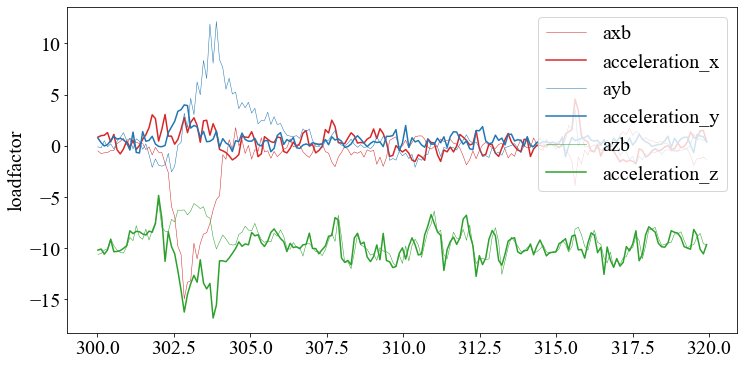

In [6]:



fig, ax = setupgraph(12, 6, 'time', ['loadfactor'])
print(ax[0])
lns = addlines(
    [acccomp.loc[300:320]], 
    ['axb', 'acceleration_x', 'ayb', 'acceleration_y', 'azb', 'acceleration_z'],
    ax[0],
    colors=['tab:red', 'tab:red', 'tab:blue', 'tab:blue', 'tab:green', 'tab:green'],
    linewidths=[0.5, 1.5,0.5, 1.5,0.5, 1.5]
    
)
ax[0].legend(lns, [l.get_label() for l in lns], loc=1)

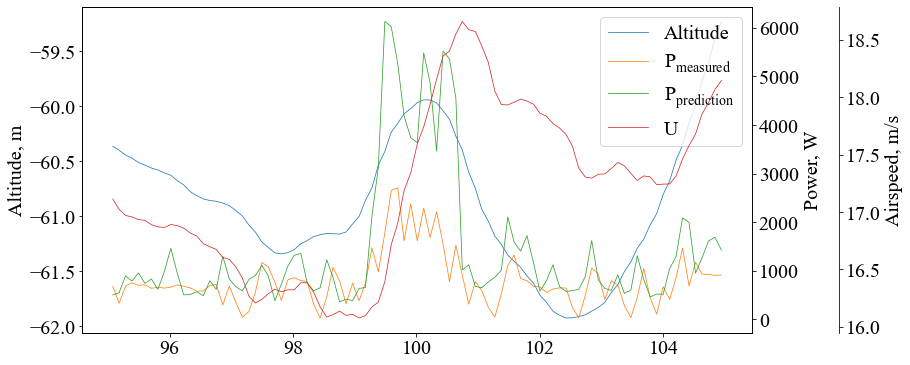

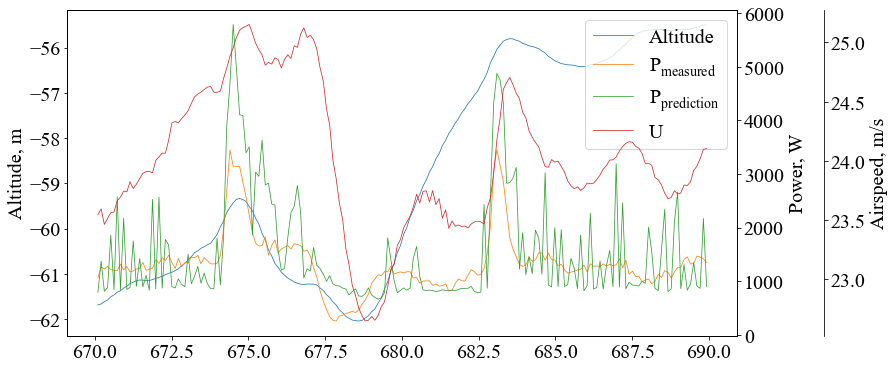

In [7]:
from scipy.signal import butter,filtfilt

def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def filterdata(data):
    data['filter_acceleration_x'] = butter_lowpass_filter(data['acceleration_x'], 0.5, 5, 2)
    data['filter_power'] = butter_lowpass_filter(data['power'], 0.5, 5, 2)
    data['filter_prediction'] = butter_lowpass_filter(data['prediction'], 0.5, 5, 2)
    data['filter_airspeed'] = butter_lowpass_filter(data['airspeed'], 0.5, 5, 2)
    data['filter_pe'] = butter_lowpass_filter(data['pe'], 0.5, 5, 2)
    data['filter_z'] = butter_lowpass_filter(data['position_z'], 0.5, 5, 2)
    return data

def plot_performance_data(data):

    fig, axes = setupgraph(12, 6, "Time, s", ['Altitude, m', 'Power, W', 'Airspeed, m/s'])
    
    lns = addlines(
        data, 
        ['position_z', 'power', 'prediction', 'airspeed'],
        [axes[0], axes[1], axes[1], axes[2]],
        ['Altitude', '$P_{measured}$', '$P_{prediction}$', 'U']
    )
    axes[0].legend(lns, [l.get_label() for l in lns], loc=1)


datas[0] = filterdata(datas[0])
datas[1] = filterdata(datas[1])

plot_performance_data([datas[0].loc[95:105]])
plot_performance_data([datas[1].loc[670:690]])


In [8]:

as_ranges = [[90, 380], [440, 650], [760, 870]]
as_rangesb = [[350, 550], [620, 710], [740, 830]]

def performance_simple(data, asranges):
    lev_data = data.loc[data['attitude_roll'] < math.radians(5)]
    level_data = lev_data.loc[lev_data['attitude_roll'] > -math.radians(5)]

    ave_values = []
    for as_range in asranges:
        ave_values.append(level_data[['power', 'airspeed', 'prediction']].loc[as_range[0]:as_range[1]].mean())

    return pd.DataFrame(ave_values)

average_performance = performance_simple(datas[0], as_ranges).append(performance_simple(datas[1], as_rangesb))
average_performance

,power,airspeed,prediction
0,692.326680,17.685223,966.048349
1,675.535272,17.695484,899.101165
2,839.636659,19.753965,919.679195
0,1283.458018,24.284498,1217.025893
1,1312.047338,24.107228,1300.934775
2,1037.056881,21.739639,1129.784828


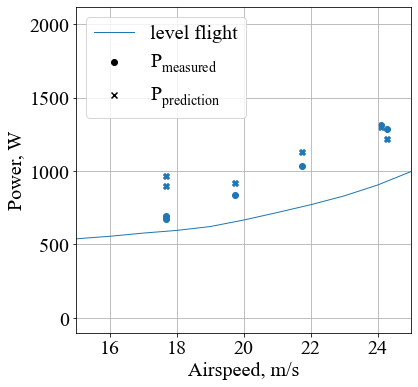

In [9]:

def prediction(prop, aircraft=buddi_light, bmass=base_mass):
    df = pd.DataFrame(range(15, 35), columns=['velocity_x'])
    df['acceleration_z'] = 9.81
    df['acceleration_x'] = 0
    df['velocity_y'] = 0
    df['velocity_z'] = 0
    df['wind_x'] = 0
    df['wind_y'] = 0
    df = generate_prediction(df, prop, aircraft, bmass)    
    return df


sl_20x13 = prediction(apc20x13)

fig, ax = matplotplot()
lns=[]
lns.append(ax.scatter(average_performance['airspeed'],average_performance['power'], color='tab:blue', marker='o',  label = '$P_{test}$, APC12x6'))
lns.append(ax.scatter(average_performance['airspeed'],average_performance['prediction'], color='tab:blue', marker='X', label = '$P_{req}$, APC12x6'))

lnb=[]
lnb += ax.plot(sl_20x13['airspeed'], sl_20x13['prediction'], label ='level flight', color='tab:blue', linewidth=1)

lnb.append(ax.scatter([0], [0], marker='o',  label = '$P_{measured}$', color='black'))
lnb.append(ax.scatter([0], [0], marker='x',  label = '$P_{prediction}$', color='black'))

ax.set_xlim(15,25)
#ax.set_ylim(500,1500)
ax.legend(lnb, [l.get_label() for l in lnb], loc=2)
ax.set_xlabel('Airspeed, m/s')
ax.set_ylabel('Power, W')
ax.grid()
saveplot('buddi_performance_validation')

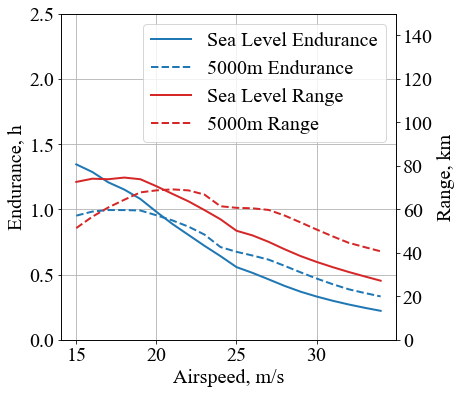

In [10]:
fig, ax = matplotplot()
buddi_light.mass = base_mass
buddi_sea_level = buddi_light.copy()
buddi_altitude = buddi_light.copy()
buddi_altitude.rho = 0.7364

buddi_sea_level = prediction(apc20x13, buddi_light, 11)
buddi_alt = prediction(apc20x13, buddi_altitude, 11)
lns=[]
lns += ax.plot(buddi_sea_level['airspeed'], buddi_sea_level['endurance'] / (60 * 60), label ='Sea Level Endurance', color='tab:blue', linewidth=2)
lns += ax.plot(buddi_alt['airspeed'], buddi_alt['endurance'] / (60 * 60), label ='5000m Endurance', color='tab:blue', linewidth=2, linestyle = '--')

ax2 = ax.twinx()
lns += ax2.plot(buddi_sea_level['airspeed'], buddi_sea_level['range'] / 1000, label ='Sea Level Range', color='tab:red', linewidth=2)
lns += ax2.plot(buddi_alt['airspeed'], buddi_alt['range'] / 1000, label ='5000m Range', color='tab:red', linewidth=2, linestyle = '--')

ax2.set_ylabel('Range, km')
rspine = ax2.spines['right']
rspine.set_position(('axes', 1))

ax.legend(lns, [l.get_label() for l in lns], loc=1)
#ax.legend(lnb, [l.get_label() for l in lnb], loc=4)
ax.set_xlabel('Airspeed, m/s')
ax.set_ylabel('Endurance, h')
ax.set_ylim(0,2.5)
ax2.set_ylim(0,150)
ax.grid()


stall speed =  10.129220319779936
stall speed =  10.99345908044783


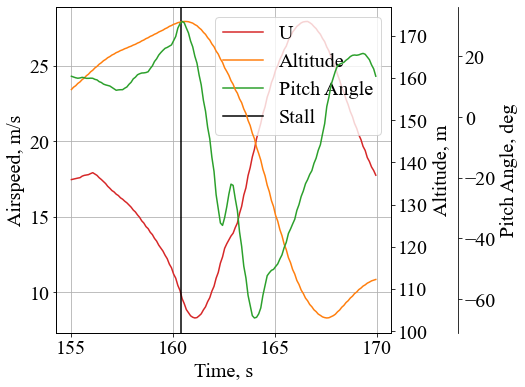

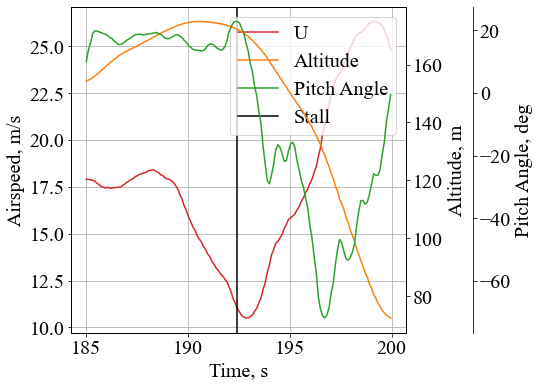

In [11]:

def plotstall(data, stalltime):
    fig, ax = matplotplot()
    #ax2 = ax.twinx()
    ax3 = ax.twinx()
    ax4 = ax.twinx()
    ax2.spines['right'].set_position(('axes', 1.4))
    ax3.spines['right'].set_position(('axes', 1))
    ax4.spines['right'].set_position(('axes', 1.2))
    
    lns = []
    lns += ax.plot(data['airspeed'], label = 'U', color='tab:red')
    #lns += ax2.plot((data['servos_1'] - 1500)*100/700, label = 'Elevator Deflection', color='tab:pink')
    lns += ax3.plot(-data['position_z'], label = 'Altitude', color='tab:orange')
    lns += ax4.plot(data['attitude_pitch'] * 180 / math.pi,label = 'Pitch Angle', color='tab:green')
    lns += [ax.axvline(stalltime, 0, 100, label = 'Stall',  color='black')]
    
    ax.set_xlabel('Time, s')
    ax.set_ylabel('Airspeed, m/s')
    #ax2.set_ylabel('Elevator Input, %')
    ax3.set_ylabel('Altitude, m')
    ax4.set_ylabel('Pitch Angle, deg')
    stall_value = data.iloc[data.index.get_loc(stalltime, method="nearest")]
    ax.legend(lns, [l.get_label() for l in lns], loc=1)
    ax.grid()
    print('stall speed = ', stall_value.airspeed)


stall1 = datas[1].loc[155:170]
stall2 = datas[1].loc[185:200]


plotstall(stall1, 160.4)
plotstall(stall2, 192.4)

saveplot('buddi_stall_test')
